# BRFSS survey predicting whether a person has diabites or not

https://www.cdc.gov/brfss/annual_data/annual_2024.html

need to download these files from the above page:
2024 BRFSS Codebook CDC 
2024 BRFSS Data (ASCII) 
download and unzip in your working file where the notebook is 

the data is not in a csv so we have to convert it, its a 'fixed width' meaning each var is seperate by a fixed width

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
#printing the first line of the file
with open("LLCP2024.ASC") as f: #<-- name of the dada file (not the codebook)
    first_line = f.readline()
#print(first_line)
print(first_line[148]) #diabetes question((Ever told) you had diabetes?) is from column 149 

3


In [3]:
first_line[1979:1981] 

'78'

In [4]:
#bmi 
int(first_line[1993:1997])/100
#this is because its suppsoed to have two decmial places

22.49

features to add: (not that the num of cols is the number of blanks)
col 284 when was the last blood test for high blood sugar 

**first part of miniproject** uisng the codebook to find variables
diabetes: col: 149
age col: 1980-1981
income 
education
bmi (body mass index) col: 1994-1997


In [ ]:
diabetes =[]
age = []
bmi = []
income = []
education = []
sex = []
general_health = []
smoking = []
drinking = []

with open("LLCP2024.ASC") as f:
    for line in f:
        #DIABETES
        value = line[148] #this has 1-9 posisble options we are only going to 7,9,blank are going to be missing values, 1 is yes, everything else is no
        if value == '1': #yes case
            diabetes.append(1)
        elif value in ['7','9',' ']: #missing value
            diabetes.append(np.nan)
        else: #no
            diabetes.append(0)
        #AGE

        value = line[1979:1981]
        age.append(int(value))
                   
        #BMI
        value = line[1993:1997]
        if value == '    ': #four blanks (missing value)
            bmi.append(np.nan)
        else: #we do have the value
            bmi.append(int(value)/100) #because it has two demcial places

        #INCOME
        value = line[203:205]
        if value == '  ':
            income.append(np.nan)
        elif value =='77':
            income.append(-1) #!the neg one indicats a unknown
        elif value == '99':
            income.append(-2) #! indicates a refused
        else:
            income.append(int(value))
        #SEX
        value = line[1975]
        sex.append(value)
        #EDUCATION
        value = line[186]
        if value == '9':
            education.append(np.nan)
        elif value == ' ':
            education.append(np.nan)
        else:
            education.append(value)
        #GENERAL HEALTH
        value = line[100]
        if value == '7' or value == '9' or value == '5':
            general_health.append(np.nan)
        else:
            general_health.append(value)
        #SMOKING
        value = line[2024:2027]
        if value == '   ' or int(value) > 40:
            smoking.append(np.nan)
        else:
            smoking.append(value)
        #DRINKING
        value = line[2056] #number of drinks per week         2048-2050       2052-2056
        if value == '9':
            drinking.append(np.nan)
        else:
            drinking.append(value)

        

df = pd.DataFrame(
    {
        'diabetes':diabetes,
        'age':age,
        'bmi':bmi,
        'income':income,
        'education':education,
        'sex':sex,
        'general_health':general_health,
        'drinking':drinking,
        'smoking':smoking
    }
)

In [6]:
df_small = df.sample(45000)

<Axes: >

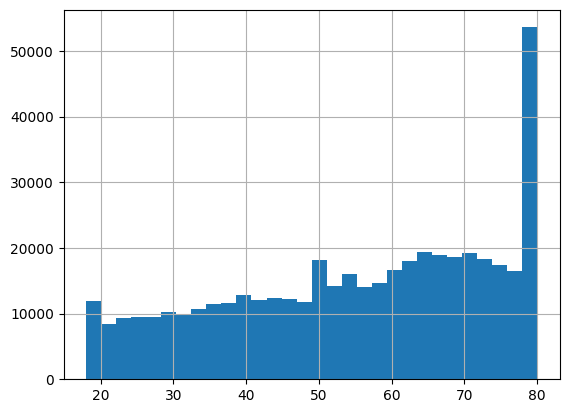

In [7]:
df.age.hist(bins=30) #much more older people in this set

<Axes: >

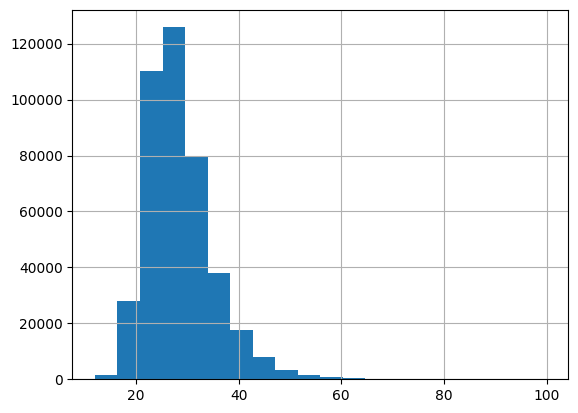

In [8]:
df.bmi.hist(bins=20)

In [9]:
df['drinking'].value_counts()

drinking
1    386812
2     24160
Name: count, dtype: int64

# Random forest model

In [10]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline #pipeline stuff
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
numerical_features = ['age','bmi']
catagorical_features = ['income','education','sex','general_health']

df.head()

,diabetes,age,bmi,income,education,sex,general_health,drinking,smoking
0,0.0,78,22.49,-2.0,4,2,3,1,NaN
1,0.0,80,25.83,11.0,6,1,1,1,020
2,0.0,59,22.53,-2.0,5,1,2,1,015
3,0.0,80,25.09,6.0,6,1,1,1,NaN
4,0.0,47,19.77,3.0,5,1,3,1,NaN


In [11]:
#pd.options.display.max_rows = 4000
#df['smoking'].value_counts(ascending=False).sort_index() # add a cut off for this 
df.isna().sum()

diabetes            1034
age                    0
bmi                43037
income              9269
education           2363
sex                    0
general_health     23509
drinking           46698
smoking           308045
dtype: int64

well smoking is useless, more then 20 cigs a day is considered heavy smoking, and so doubling it would give us like 25,000 remaining people out of the 150,000 people which is like so few people

also this is the reminder 
changing the classification threshold

In [12]:

df.dropna(subset=['diabetes'],inplace=True)
df_small.dropna(subset=['diabetes'],inplace=True)


In [13]:
X_small = df_small.drop('diabetes',axis=1)
y_small = df_small['diabetes']
X = df.drop('diabetes',axis=1)
y = df['diabetes']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train_small,X_test_small,y_train_small,y_test_small = train_test_split(X_small,y_small)

this is also basically useless, the niaaa classifies heavy drinking for men at least as 15 or more a week, or average 2 a day, so doubling that with 4 a day, would leave us with barely 233,000 (a 4th of the dataset) left being useful

In [14]:
from sklearn.model_selection import FixedThresholdClassifier
#and manuel test out thresholds
#use confusion matrix too

#to tune the threshold use the imbalanced dataset notebook
#remember tune hyperparams based on a metric that doesnt use the threshold and then tune threshold

catagorical_features = ['income','education','sex','drinking','general_health']
numeric_features = ['age','bmi','smoking']

numeric_processor=Pipeline(steps = [
    ('imputer',SimpleImputer(strategy='constant', fill_value=0)), #fill value bacuse these were people who were not asked #! CHANGE AT SOME POINT
    ('scaler',StandardScaler())
    ])

categorical_processor=Pipeline(steps = [
    ('encoder',OneHotEncoder(handle_unknown='ignore',min_frequency=.01))
    ])

feature_processor = ColumnTransformer(transformers = [ 
    ('num',numeric_processor,numeric_features),
    ('cat',categorical_processor,catagorical_features)],
    )


In [15]:
from sklearn.ensemble import RandomForestClassifier
pipe_clf = Pipeline(steps=[
    ('feature_processor',feature_processor),
    ('clf',RandomForestClassifier())
    ])
pipe_clf

,steps,"[('feature_processor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
from sklearn.model_selection import RandomizedSearchCV

param_dic = {
    'clf__n_estimators': range(20,250),
    'clf__max_depth': range(2,10),
    'clf__min_samples_split': range(10,250),
    'clf__min_samples_leaf': range(5,250)
}
grid = RandomizedSearchCV(pipe_clf,
                          param_dic,
                          n_iter=50,
                          scoring='average_precision',
                          n_jobs=-1,
                          cv=5
)
grid.fit(X_train_small,y_train_small)

,estimator,Pipeline(step...lassifier())])
,param_distributions,"{'clf__max_depth': range(2, 10), 'clf__min_samples_leaf': range(5, 250), 'clf__min_samples_split': range(10, 250), 'clf__n_estimators': range(20, 250)}"
,n_iter,50
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [17]:
#saving the classifer model as a pickle file 
import joblib
pipe_clf = grid.best_estimator_
joblib.dump(pipe_clf,'pipe_clf.pkl')


['pipe_clf.pkl']

In [18]:
pipe_clf = joblib.load('pipe_clf.pkl')

In [19]:
#recall curve <-
from sklearn.metrics import precision_recall_curve
y_test_proba = pipe_clf.predict_proba(X_test_small)[:,1]
y_test_proba

array([0.10099642, 0.13568622, 0.24646521, ..., 0.16675214, 0.03194062,
       0.10475461])

In [20]:
precision, recall, threshold = precision_recall_curve(y_test_small,y_test_proba)

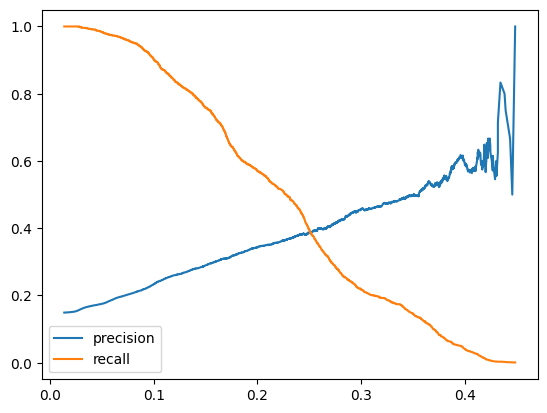

In [21]:
plt.plot(threshold,precision[0:-1],label='precision')
plt.plot(threshold,recall[0:-1],label='recall')
plt.legend()


In [22]:
threshold = .15
pipe_clf_threshold = FixedThresholdClassifier(pipe_clf,threshold=threshold)

In [23]:
# a fake person 
df.head(1)

,diabetes,age,bmi,income,education,sex,general_health,drinking,smoking
0,0.0,78,22.49,-2.0,4,2,3,1,NaN


In [24]:
X_new = pd.DataFrame({
                      'age':[45,50,25,30],
                      'bmi':[30,35,20,37],
                      'income':[2,4,3,3],
                      'education':['4','4','3','4'],
                      'sex':['1','2','2','1'],
                      'general_health':['3','4','4','2'],
                      'drinking':['1','1','1','0'],
                      'smoking':['1','15','3','13']
                      })

In [25]:
X_test.dtypes

age                 int64
bmi               float64
income            float64
education          object
sex                object
general_health     object
drinking           object
smoking            object
dtype: object

In [26]:
X_new

,age,bmi,income,education,sex,general_health,drinking,smoking
0,45,30,2,4,1,3,1,1
1,50,35,4,4,2,4,1,15
2,25,20,3,3,2,4,1,3
3,30,37,3,4,1,2,0,13


In [27]:
pipe_clf_threshold.predict(X_test)

array([1., 0., 0., ..., 0., 1., 0.])

In [28]:
pipe_clf_threshold.predict(X_new)

array([0., 1., 0., 0.])